# Análise do Nível de Manutenibilidade
<br>
#### Objetivo:<br>
É importante acompanhar se as issues de correção estão levando mais ou menos tempo, e se o software está com os números de defeitos aumentando ou diminuíndo, ou seja, se a sua modificabilidade está melhorando. Uma boa avaliação desses números é conseguir ter correções mais rápidas e sem efeitos colaterais.
Auxiliar futuras refatorações: Quais devem ser as principais para eliminar problemas;<br>
A partir de uma coleção de métricas coletadas automaticamente e de uma forma objetiva de interpretar seus valores, engenheiros de software podem monitorar características especícas do seu código assim como implementações problemáticas para tomar melhores decisões ao (re)escrevê-las.<br>
<br>
#### Vantagens:<br>
-- Possibilita a rápida identificação de falhas e permite ações de correções na mesma velocidade;<br>
-- O desenvolvimento e a aplicação de novos recursos fica mais fácil e rápido;<br>
-- Há um melhor controle de acesso autorizado para as revisões;<br>
-- Conflitos de mudanças são resolvidos com maior agilidade;<br>
-- Erros e códigos de risco são encontrados mais facilmente;<br>
-- Programadores passam a ter uma visão analítica objetiva, que possibilita e ajuda no reconhecimento de onde os mesmo foram ou não precisos e desatentos;<br>
-- ** Com a exclusão de determinadas classes de defeitos, a equipe se encontra concentrada em outros tipos de eficiência do projeto. **<br>
<br>
Não estou analizando:<br>
-- Complexidade Ciclomática (desvios uma função possui: cada comando if, switch, for, while);<br>
-- Metodos com muitos parâmetros;<br>
-- Outras métricas (Sonar);<br>
<br>
#### Próximos trabalhos:<br>
-- Checkins com uma unit;<br>
-- Cruzar dados do RTC;<br>
<br>


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

arquivos = ['csv\main_changeset.csv', 'csv\HorasPorSalt2014ate2017.csv']

### Changeset

Extraido do TFS:<br>
```python
tf hist /noprompt /recursive /format:detailed /version:D"1/1/2015"~D"31/12/2015" $/fPJ/PJ/build/release > 
```


** Utilizado arquivo TFS.ipynb para conversão em CSV.

In [3]:
dfChangesets = pd.read_csv(arquivos[0], encoding='ISO-8859-1', delimiter=';', header=None, 
                 names= ["Salt", "Changeset", "Desenv", "Data", "Descricao", "File", "Filename"])

In [4]:
dfChangesets.shape

(200775, 7)

In [5]:
dfChangesets[dfChangesets.Salt == '252785/1']

,Salt,Changeset,Desenv,Data,Descricao,File,Filename


In [3]:
#Correcao = ['anderson.albuquerque', 'darlley.silva', 'murilo.guollo', 'wilian.ivo', 'gessileini.clinio', 'william.colombo', 'roni.beltramin', 'cesar.pamplona', 'taissiane.moroso', 'douglas.zuliani', 'francisco.gomes'] 

In [5]:
#def Equipe(d): #desenv
#    return d in Correcao
#dfChangesets['Correcao'] = dfChangesets.Desenv.apply(Equipe)

In [9]:
def Extensao(d): 
    retorno = 'FOL'
    if len(d.split('.')) > 1:
        retorno = str(d).split(';')[0]
        retorno = retorno.split('.')
        retorno = retorno[len(retorno) - 1]
    return retorno

dfChangesets['extensao'] = dfChangesets.File.apply(Extensao)
#dfChangesets[['extensao', 'File']]
dfChangesets.extensao.value_counts().to_frame().head(30)

,extensao
pas,81406
dcu,27524
dfm,21808
FOL,10092
res,6879
DH4,6383
dpk,3455
obj,2919
dproj,2598
dpr,2509


In [10]:
ignorar = ['uspjConstante.pas', 'uspjFuncoes.pas', 'uspjParametro.pas', 'uspjTelaMenu.pas', 'uspjMensagem3.pas', 
           'uspjMensagem2.pas', 'uspjMensagem.pas']

dfChangesets = dfChangesets[dfChangesets.extensao == 'pas']

dfChangesets['ignorar'] = dfChangesets.File.apply(lambda y: True if y in ignorar else False)
dfChangesets = dfChangesets[dfChangesets.ignorar == False]

dfChangesets

,Salt,Changeset,Desenv,Data,Descricao,File,Filename,extensao,ignorar
0,263572/1,554269,anderson.albuquerque,29/12/2017,SALT 263572/1 - Correção para que o Sistema ig...,uspjCalculoPrazo.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False
1,263572/1,554269,anderson.albuquerque,29/12/2017,SALT 263572/1 - Correção para que o Sistema ig...,uspjParametroCalculoPrazo.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False
2,263572/1,554269,anderson.albuquerque,29/12/2017,SALT 263572/1 - Correção para que o Sistema ig...,uspjPendenciaPrazo.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False
5,261519/1,554254,anderson.albuquerque,29/12/2017,SALT 261519/1 - Alterado sistema para permitir...,uspjConsInfAdicControladaComCadastro.pas,/fPJ/PJ/build/main/pjDev/src/pj/Cliente/uspjCo...,pas,False
8,258433/2,554248,anderson.albuquerque,29/12/2017,SALT 258433/2 - Corrigido Problema na consulta...,uspjPublicdiarioServ.pas,/fPJ/PJ/build/main/pjDev/src/pj/Servidor/uspjP...,pas,False
9,262499/1,554222,anderson.albuquerque,29/12/2017,SALT 262499/1 - Corrigido problema na atividad...,uspjConfigImpressao.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False
10,260508/1,554202,anderson.albuquerque,29/12/2017,SALT 260508/1 - Correção da apresentação do ca...,uspjSelectFluxoDocumento.pas,/fPJ/PJ/build/main/pjDev/src/pj/Servidor/uspjS...,pas,False
19,1/1,554196,olimar.santos,29/12/2017,Merge correções Tokyo,uedtEditorBasico5Normal.pas,/fPJ/PJ/build/main/pjDev/src/3rd_party/edtDev/...,pas,False
21,1/1,554196,olimar.santos,29/12/2017,Merge correções Tokyo,dxDBGrid.pas,/fPJ/PJ/build/main/pjDev/src/3rd_party/pacDev/...,pas,False
27,1/1,554196,olimar.santos,29/12/2017,Merge correções Tokyo,uspPopupScrollForm.pas,/fPJ/PJ/build/main/pjDev/src/3rd_party/sp4Dev/...,pas,False


# Salts

Dados exportados do SAC via SQL.<br>

> OndeDrive/SAC/Horas.sql
```sql
SELECT DISTINCT 
       ia.NUATENDIMENTO,
       IA.NUITEM,
       ia.NUATENDIMENTO || '/' || IA.NUITEM AS SALT,
       ia.CDTIPOATENDSOFT,
       RA.CDORIGEMATEND AS ORIGEM,
       --ra.NUSEQVERSAO,
       ve.NURELEASE,
       /*(SELECT COUNT(1)
                 FROM SAC.ESACATIVIDADE AA
                WHERE AA.CDPROJETO = IA.CDPROJETO
                  AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
                  AND AA.NUITEM = IA.NUITEM
                  AND AA.CDTIPOATIVIDADE = 120) AS PRIORIDADES_SOLICITADAS,*/
       /*CASE WHEN IA.DTLIMSOLUCAO < 
       (SELECT MAX(AA.DTREALFINAL)
                 FROM SAC.ESACATIVIDADE AA
                WHERE AA.CDPROJETO = IA.CDPROJETO
                  AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
                  AND AA.NUITEM = IA.NUITEM)
       THEN 'VENCIDA' ELSE 'DENTRO_PRAZO' END SITUACAO_SLA,*/
       CLI.SGCLIENTE AS CLIENTE,
       IA.DTREGISTRO AS DATA_CADASTRO,
       IA.DTLIMSOLUCAO AS DATA_SLA,
       CASE IA.CDPRIORIDADE 
         WHEN 6 THEN 'ZERO/CRÍTICA'
         WHEN 5 THEN 'UM/IMPEDITIVA'
         WHEN 1 THEN 'DOIS/ALTA'
         WHEN 2 THEN 'TRES/MÉDIA'
         WHEN 3 THEN 'QUATRO/BAIXA'
         WHEN 4 THEN 'INDEFINIDA'
       END SEVERIDADE,
       CASE IA.CDPRIORIDADE 
         WHEN 6 THEN 8
         WHEN 5 THEN 5
         WHEN 1 THEN 4
         WHEN 2 THEN 3
         WHEN 3 THEN 2
         WHEN 4 THEN 3
       END PONTUACAO_SEVERIDADE,
       SIT.DESITUACAOATEND AS SITUACAO_SALT,
       /*CASE WHEN (SELECT COUNT(1)
                 FROM SAC.ESACATIVIDADE AA
                WHERE AA.CDPROJETO = IA.CDPROJETO
                  AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
                  AND AA.NUITEM = IA.NUITEM
                  AND AA.CDTIPOATIVIDADE IN (243,303)) > 0 THEN 'SIM' ELSE 'NÃO' END AS REJEITE,*/
       AA.NUSEQATIVIDADE,
       AA.CDTIPOATIVIDADE,
       TA.DETIPOATIVIDADE,
       AA.CDUSUARIOENC,
       AA.DTREALINICIO,
       AA.DTREALFINAL,
       '0' || CAST(AA.QTHORASREAL AS VARCHAR(10)) AS QTHORASREAL,
    (SELECT '0' || CAST(SUM(AA.QTHORASREAL) AS VARCHAR(10))
                 FROM SAC.ESACATIVIDADE AA
                WHERE AA.CDPROJETO = IA.CDPROJETO
                  AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
                  AND AA.NUITEM = IA.NUITEM
                  --AND AA.CDTIPOATIVIDADE IN (243,303)
                  ) AS HORASTOTAIS
  FROM sac.ESACREGISTROATEND ra
 LEFT JOIN sac.ESACVERSAO ve
    ON ra.CDPROJETO = ve.CDPROJETO
   AND ra.CDSISTEMA = ve.CDSISTEMA
   AND ra.NUSEQVERSAO = ve.NUSEQVERSAO
  JOIN sac.ESACITEMATEND ia
    ON ia.cdProjeto = ia.CDPROJETO
   AND ia.NUATENDIMENTO = ra.NUATENDIMENTO
  JOIN SAC.ESACSITUACAOATEND SIT
    ON SIT.CDSITUACAOATEND = IA.CDSITUACAOATEND
  JOIN sac.ESACATIVIDADE a
    ON a.cdProjeto = ia.CDPROJETO
   AND a.NUATENDIMENTO = ia.NUATENDIMENTO
   AND a.NUITEM = ia.NUITEM
   AND a.CDTIPOATIVIDADE in (162)
  JOIN SAC.ESACCLIENTE CLI
    ON CLI.CDCLIENTE = ra.CDCLIENTE    
  JOIN SAC.ESACATIVIDADE AA
    ON AA.CDPROJETO = IA.CDPROJETO
   AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
   AND AA.NUITEM = IA.NUITEM    
 LEFT  JOIN SAC.ESACTIPOATIVIDADE TA
    ON AA.CDTIPOATIVIDADE = TA.CDTIPOATIVIDADE
 WHERE ra.cdProjeto = 3
--   AND ra.CDORIGEMATEND = 10
   AND ra.CDSISTEMA IN (31,93)
--   AND ra.CDCLIENTE <> 3969
--   AND a.DTENCERRAMENTO IS NULL
--   AND ia.DTLIMSOLUCAO IS NOT NULL
--   AND SIT.CDSITUACAOATEND=65
   AND VARCHAR_FORMAT (ia.DTREGISTRO,'YYYY-MM-DD') > '2014-01-01'
--AND ra.NUATENDIMENTO = 263466
ORDER BY ia.NUATENDIMENTO, IA.NUITEM, AA.NUSEQATIVIDADE
```


In [11]:
dfSalts = pd.read_csv(arquivos[1], encoding='ISO-8859-1', delimiter=',')
dfSalts

,NUATENDIMENTO,NUITEM,SALT,CDTIPOATENDSOFT,ORIGEM,NURELEASE,PRIORIDADES_SOLICITADAS,SITUACAO_SLA,CLIENTE,DATA_CADASTRO,...,PONTUACAO_SEVERIDADE,SITUACAO_SALT,NUSEQATIVIDADE,CDTIPOATIVIDADE,CDUSUARIOENC,DETIPOATIVIDADE,DTREALINICIO,DTREALFINAL,QTHORASREAL,HORASTOTAIS
0,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,3,Encerrado,2,244,FERNANDO.OLIVEIRA,Roteamento Suporte,2017-05-16,2017-05-16,0.500,10.793
1,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,3,Encerrado,3,654,MURIEL.PREUSS,Avaliação atendimento - Suporte,2017-05-16,2017-05-16,2.000,10.793
2,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,3,Encerrado,4,83,MURIEL.PREUSS,Determinação das Causas Possíveis,2017-05-16,2017-05-16,0.166,10.793
3,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,3,Encerrado,5,120,MURIEL.PREUSS,Solicitação de prioridade,2017-05-16,2017-05-16,0.183,10.793
4,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,3,Encerrado,6,162,FABIANO.VELOSO,Avaliação atendimento - Correção,2017-05-16,2017-05-16,0.166,10.793
5,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,3,Encerrado,7,120,PORTALCLIENTE,Solicitação de prioridade,2017-05-24 08:35:48,2017-05-24 08:35:48,0.016,10.793
6,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,3,Encerrado,8,162,PEDRO.MARTINS,Avaliação atendimento - Correção,2017-05-17,2017-05-17,3.000,10.793
7,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,3,Encerrado,9,642,PORTALCLIENTE,Ag. cliente - Recategorização,2017-05-17 11:06:07,2017-05-17 11:06:07,0.016,10.793
8,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,3,Encerrado,10,16,PORTALCLIENTE,Avaliação do atendimento,2017-05-24 08:35:48,2017-05-24 08:35:48,0.016,10.793
9,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,3,Encerrado,11,657,MURIEL.PREUSS,Avaliação resposta - Recategorização,2017-05-17,2017-05-17,0.333,10.793


In [4]:
dfSalts.CDTIPOATENDSOFT.value_counts().to_frame()

,CDTIPOATENDSOFT
1,54378
2,4541
5,1368
253,872
46,755
16,665
4,636
86,298
119,264
18,183


In [12]:
Salts_counts = dfChangesets.Salt.value_counts()
#Salts_uniques = dfChangesets.Salt.unique()#.to_frame()

dfChangesets['conta'] = dfChangesets.Salt.apply(lambda y: 1 if y not in Salts_counts else Salts_counts[y])
dfChangesets['apagar'] = dfChangesets.conta.apply(lambda y: True if y>500 else False)

In [13]:
dfChangesets = dfChangesets[dfChangesets.apagar == False]

In [14]:
#dfChangesets = dfChangesets[dfChangesets.Correcao == True]
atividades = [5, 4, 248, 252, 244, 184, 223, 246];
dfSalts['alteracao'] = dfSalts.CDTIPOATENDSOFT.apply(lambda y: True if y in atividades else False)

#005	Alteração
#004	Nova implementação
#248	Melhoria de ferramenta
#252	Melhoria de ferramenta
#244	Melhoria de ferramenta
#184	Melhoria de ferramenta
#223	Melhoria de ferramenta
#246	Melhoria de ferramenta


In [13]:
dfSalts.head(30)

,NUATENDIMENTO,NUITEM,SALT,CDTIPOATENDSOFT,ORIGEM,NURELEASE,PRIORIDADES_SOLICITADAS,SITUACAO_SLA,CLIENTE,DATA_CADASTRO,...,SITUACAO_SALT,NUSEQATIVIDADE,CDTIPOATIVIDADE,CDUSUARIOENC,DETIPOATIVIDADE,DTREALINICIO,DTREALFINAL,QTHORASREAL,HORASTOTAIS,alteracao
0,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,Encerrado,2,244,FERNANDO.OLIVEIRA,Roteamento Suporte,2017-05-16,2017-05-16,0.500,10.793,False
1,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,Encerrado,3,654,MURIEL.PREUSS,Avaliação atendimento - Suporte,2017-05-16,2017-05-16,2.000,10.793,False
2,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,Encerrado,4,83,MURIEL.PREUSS,Determinação das Causas Possíveis,2017-05-16,2017-05-16,0.166,10.793,False
3,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,Encerrado,5,120,MURIEL.PREUSS,Solicitação de prioridade,2017-05-16,2017-05-16,0.183,10.793,False
4,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,Encerrado,6,162,FABIANO.VELOSO,Avaliação atendimento - Correção,2017-05-16,2017-05-16,0.166,10.793,False
5,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,Encerrado,7,120,PORTALCLIENTE,Solicitação de prioridade,2017-05-24 08:35:48,2017-05-24 08:35:48,0.016,10.793,False
6,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,Encerrado,8,162,PEDRO.MARTINS,Avaliação atendimento - Correção,2017-05-17,2017-05-17,3.000,10.793,False
7,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,Encerrado,9,642,PORTALCLIENTE,Ag. cliente - Recategorização,2017-05-17 11:06:07,2017-05-17 11:06:07,0.016,10.793,False
8,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,Encerrado,10,16,PORTALCLIENTE,Avaliação do atendimento,2017-05-24 08:35:48,2017-05-24 08:35:48,0.016,10.793,False
9,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,Encerrado,11,657,MURIEL.PREUSS,Avaliação resposta - Recategorização,2017-05-17,2017-05-17,0.333,10.793,False


In [15]:
dfAtividades = dfSalts.groupby(['CDTIPOATIVIDADE', 'DETIPOATIVIDADE'])['SALT'].count().to_frame().sort_values(by='SALT', ascending=False)
dfAtividades = [83, 162, 51, 188, 90, 336, 8, 45, 119, 15, 344]
#dfAtividades.Codigo.value_counts
#083	Determinacao das Causas Possiveis
#162	Avalicao atendimento - Correcao
#051	Sincronizacao de fontes para versao de correcao
#188	Avaliacao atendimento - Desenvolvimento PJ
#090	Suporte e apoio t้cnico ao cliente interno
#336	Codificar solucao
#008	Codificacao
#045	Codificacao devido a testes reprovados
#119	Avaliacao atendimento - Desenvolvimento
#015	Script
#344	Corrigir codificacao

dfSalts['AtividadeDesenv'] = dfSalts.CDTIPOATIVIDADE.apply(lambda y: True if y in dfAtividades else False)
#dfSalts['HorasDesenv'] = dfSalts.AtividadeDesenv.apply(lambda y: dfSalts.QTHORASREAL if y == True else 0) #Pupilo
#dfSalts['HorasDesenv'] = 0.00
#dfSalts[dfSalts.AtividadeDesenv == True].HorasDesenv = dfSalts.QTHORASREAL #Pupilo
dfSalts.HorasDesenv = dfSalts.QTHORASREAL
#dfSalts['HorasDesenv'] = dfSalts['AtividadeDesenv', 'QTHORASREAL'].apply(lambda Ativ, Horas: 0 if Ativ == False else Horas)
dfSalts[dfSalts.AtividadeDesenv == True]

,NUATENDIMENTO,NUITEM,SALT,CDTIPOATENDSOFT,ORIGEM,NURELEASE,PRIORIDADES_SOLICITADAS,SITUACAO_SLA,CLIENTE,DATA_CADASTRO,...,NUSEQATIVIDADE,CDTIPOATIVIDADE,CDUSUARIOENC,DETIPOATIVIDADE,DTREALINICIO,DTREALFINAL,QTHORASREAL,HORASTOTAIS,alteracao,AtividadeDesenv
2,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,4,83,MURIEL.PREUSS,Determinação das Causas Possíveis,2017-05-16,2017-05-16,0.166,10.793,False,True
4,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,6,162,FABIANO.VELOSO,Avaliação atendimento - Correção,2017-05-16,2017-05-16,0.166,10.793,False,True
6,58130,6,58130/6,1,10,03030917,2,VENCIDA,PGE/PE,2017-05-15 17:51:01,...,8,162,PEDRO.MARTINS,Avaliação atendimento - Correção,2017-05-17,2017-05-17,3.000,10.793,False,True
23,102892,3,102892/3,1,10,03051105,2,VENCIDA,PGE/SP,2016-01-20 17:22:25,...,8,162,JULIANA.ALVES,Avaliação atendimento - Correção,2016-02-15,2016-02-15,1.500,21.153,False,True
31,102892,3,102892/3,1,10,03051105,2,VENCIDA,PGE/SP,2016-01-20 17:22:25,...,16,162,JULIANA.ALVES,Avaliação atendimento - Correção,2016-02-29,2016-02-29,2.000,21.153,False,True
34,102892,3,102892/3,1,10,03051105,2,VENCIDA,PGE/SP,2016-01-20 17:22:25,...,19,188,GUILHERME.ARAUJO,Avaliação atendimento - Desenvolvimento PJ,2016-03-18,2016-03-18,4.000,21.153,False,True
36,102892,3,102892/3,1,10,03051105,2,VENCIDA,PGE/SP,2016-01-20 17:22:25,...,21,83,GUILHERME.ARAUJO,Determinação das Causas Possíveis,2016-03-18 15:32:08,2016-03-18 15:32:08,0.250,21.153,False,True
38,102892,3,102892/3,1,10,03051105,2,VENCIDA,PGE/SP,2016-01-20 17:22:25,...,23,45,GUILHERME.ARAUJO,Codificação devido a testes reprovados,2016-03-24,2016-03-24,0.500,21.153,False,True
40,102892,3,102892/3,1,10,03051105,2,VENCIDA,PGE/SP,2016-01-20 17:22:25,...,25,188,FRANCISCO.GOMES,Avaliação atendimento - Desenvolvimento PJ,2016-04-13 13:42:23,2016-04-13 13:42:23,0.082,21.153,False,True
42,102892,3,102892/3,1,10,03051105,2,VENCIDA,PGE/SP,2016-01-20 17:22:25,...,27,336,FRANCISCO.GOMES,Codificar solução,2016-04-13 11:26:52,2016-04-13 11:26:52,2.500,21.153,False,True


In [1]:
#dfSalts['PerdeuPrazoSla'] = dfSalts.SITUACAO_SLA  == 
#dfSalts.head(5)

In [16]:
dfSalts['Salt'] = dfSalts.SALT
dfSaltsMerge = dfSalts[dfSalts.AtividadeDesenv == True]
dfSaltsMerge = dfSaltsMerge[['Salt','HORASTOTAIS', 'alteracao']]
dfSaltsMerge = dfSaltsMerge.drop_duplicates()
dfSaltsMerge.set_index('Salt').to_csv(path_or_buf=str('csv\SaltHorasDesenv.csv'))
dfSaltsMerge

,Salt,HORASTOTAIS,alteracao
2,58130/6,10.793,False
23,102892/3,21.153,False
55,102892/4,20.659,False
64,104466/42,1.166,True
66,104466/84,1.000,False
68,104466/94,0.766,False
71,104466/96,1.500,False
72,104466/116,0.282,False
75,104466/117,2.032,False
78,104466/118,0.016,False


In [17]:
dfSalts['Salt'] = dfSalts.SALT
#dfChangesets = dfChangesets[dfChangesets.Data.notnull()][(dfChangesets.Data.dropna().str.contains('2017'))]
dfChangesets = dfChangesets.merge(dfSaltsMerge, how='right', on='Salt')

In [18]:
dfChangesets.query('conta > 1')

,Salt,Changeset,Desenv,Data,Descricao,File,Filename,extensao,ignorar,conta,apagar,HORASTOTAIS,alteracao
0,263572/1,554269.0,anderson.albuquerque,29/12/2017,SALT 263572/1 - Correção para que o Sistema ig...,uspjCalculoPrazo.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False,3.0,False,21.082,False
1,263572/1,554269.0,anderson.albuquerque,29/12/2017,SALT 263572/1 - Correção para que o Sistema ig...,uspjParametroCalculoPrazo.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False,3.0,False,21.082,False
2,263572/1,554269.0,anderson.albuquerque,29/12/2017,SALT 263572/1 - Correção para que o Sistema ig...,uspjPendenciaPrazo.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False,3.0,False,21.082,False
9,252966/14,553610.0,juliano,27/12/2017,SALT 252966/14 - Correções relacionadas a prob...,udigImprimeProcesso.pas,/fPJ/PJ/build/main/pjDev/src/3rd_party/digDev/...,pas,False,4.0,False,47.892,False
10,252966/14,553610.0,juliano,27/12/2017,SALT 252966/14 - Correções relacionadas a prob...,udigGeral.pas,/fPJ/PJ/build/main/pjDev/src/3rd_party/digDev/...,pas,False,4.0,False,47.892,False
11,252966/14,553610.0,juliano,27/12/2017,SALT 252966/14 - Correções relacionadas a prob...,uspjImprimeProcesso.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False,4.0,False,47.892,False
12,252966/14,543490.0,roni.beltramin,19/10/2017,O sistema não estava imprimindo os anexos corr...,udigImprimeProcesso.pas,/fPJ/PJ/build/main/pjDev/src/3rd_party/digDev/...,pas,False,4.0,False,47.892,False
13,243357/38,553589.0,darlley.silva,26/12/2017,SALT 243357/38 - Rotinas de ajuizamento não ma...,uspjMensagemWSPetIniciaisFactory.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False,4.0,False,21.564,False
14,243357/38,553589.0,darlley.silva,26/12/2017,SALT 243357/38 - Rotinas de ajuizamento não ma...,uspjTratamentoRetornoWSAltSitProcProbAjuiz.pas...,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False,4.0,False,21.564,False
15,243357/38,553589.0,darlley.silva,26/12/2017,SALT 243357/38 - Rotinas de ajuizamento não ma...,uspjTratamentoRetornoWSLancarMovProbAjuiz.pas;...,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False,4.0,False,21.564,False


In [19]:
dfChangesets['Media'] = dfChangesets.HORASTOTAIS / dfChangesets.conta

In [22]:
HorasFile = dfChangesets[dfChangesets.alteracao == False].groupby('File', as_index=False).agg({"Media": "sum"})
HorasFile = HorasFile.sort_values(by='Media', ascending=False)
HorasFile #.head(100)

,File,Media
851,uspjPendenciaPrazoServ.pas,1235.101502
883,uspjProcessoServ.pas,1217.975727
634,uspjEdicaoDocumento.pas,871.144909
1069,uspjVisualizaFluxoTrabalho.pas,743.791864
365,uspjCadProcessoMovBase.pas,731.976755
593,uspjDistProcessoServ.pas,711.072462
768,uspjIntimacaoeletServ.pas,634.925659
629,uspjDocEmitidoServ.pas,599.999226
362,uspjCadProcessoEF.pas,573.195392
1070,uspjVisualizaProcesso.pas,570.244119


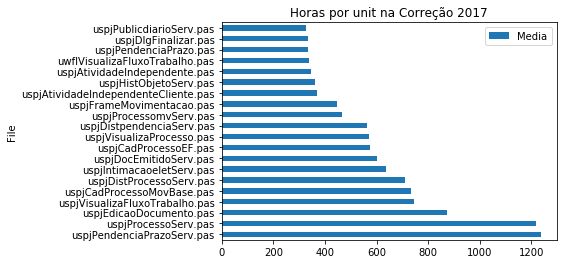

In [21]:
HorasFile[:20].set_index('File').plot(kind='barh')
plt.title("Horas por unit em Correção 2017")
plt.show()

In [23]:
dfChangesets[dfChangesets.File == 'uspjVarDistProcur.pas']

,Salt,Changeset,Desenv,Data,Descricao,File,Filename,extensao,ignorar,conta,apagar,HORASTOTAIS,alteracao,Media
3396,191106/80,410824.0,roni.beltramin,26/11/2015,SALT 191106/80 - Erro no midas.dll e outras s...,uspjVarDistProcur.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False,18.0,False,2.016,False,0.112


In [26]:
dfChangesets[dfChangesets.Salt == '191106/80']

,Salt,Changeset,Desenv,Data,Descricao,File,Filename,extensao,ignorar,conta,apagar,HORASTOTAIS,alteracao,Media
3389,191106/80,410824.0,roni.beltramin,26/11/2015,SALT 191106/80 - Erro no midas.dll e outras s...,uspjCadProcuradorHist.pas,/fPJ/PJ/build/main/pjDev/src/pj/Cliente/uspjCa...,pas,False,18.0,False,2.016,False,0.112
3390,191106/80,410824.0,roni.beltramin,26/11/2015,SALT 191106/80 - Erro no midas.dll e outras s...,uspjConsProcRPDev.pas,/fPJ/PJ/build/main/pjDev/src/pj/Cliente/uspjCo...,pas,False,18.0,False,2.016,False,0.112
3391,191106/80,410824.0,roni.beltramin,26/11/2015,SALT 191106/80 - Erro no midas.dll e outras s...,uspjFrameDistFluxo.pas,/fPJ/PJ/build/main/pjDev/src/pj/Cliente/uspjFr...,pas,False,18.0,False,2.016,False,0.112
3392,191106/80,410824.0,roni.beltramin,26/11/2015,SALT 191106/80 - Erro no midas.dll e outras s...,uspjFramePesos.pas,/fPJ/PJ/build/main/pjDev/src/pj/Cliente/uspjFr...,pas,False,18.0,False,2.016,False,0.112
3393,191106/80,410824.0,roni.beltramin,26/11/2015,SALT 191106/80 - Erro no midas.dll e outras s...,uspjVisualizaFluxoTrabalho.pas,/fPJ/PJ/build/main/pjDev/src/pj/Cliente/uspjVi...,pas,False,18.0,False,2.016,False,0.112
3394,191106/80,410824.0,roni.beltramin,26/11/2015,SALT 191106/80 - Erro no midas.dll e outras s...,uspjDistribuicaoCandidatos.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False,18.0,False,2.016,False,0.112
3395,191106/80,410824.0,roni.beltramin,26/11/2015,SALT 191106/80 - Erro no midas.dll e outras s...,uspjParametrosAgrupamento.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False,18.0,False,2.016,False,0.112
3396,191106/80,410824.0,roni.beltramin,26/11/2015,SALT 191106/80 - Erro no midas.dll e outras s...,uspjVarDistProcur.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False,18.0,False,2.016,False,0.112
3397,191106/80,410824.0,roni.beltramin,26/11/2015,SALT 191106/80 - Erro no midas.dll e outras s...,uspjWsservico.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,pas,False,18.0,False,2.016,False,0.112
3398,191106/80,410824.0,roni.beltramin,26/11/2015,SALT 191106/80 - Erro no midas.dll e outras s...,uspjDistdevedorServ.pas,/fPJ/PJ/build/main/pjDev/src/pj/Servidor/uspjD...,pas,False,18.0,False,2.016,False,0.112


In [ ]:
#Nao funcionando devido a consulta do SQC
Prazo = dfChangesets[dfChangesets.PerdeuPrazoSla == True].groupby('File', as_index=False).agg({"Salt": "count"})
Prazo = Prazo.sort_values(by='Salt', ascending=False)
Prazo.head(10)

Prazo[:20].set_index('File').plot(kind='barh')
plt.title("Prazo Estourado SLA")
plt.show()